In [3]:
!pip install pysam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 58.7 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pysam
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import scipy
from scipy.stats import chisquare 
from pandas import DataFrame


In [9]:
vcf = pysam.VariantFile('/content/drive/MyDrive/experiment_48.vcf')

[1 bod] Koliko je subjekata ukupno učestvovalo u studiji? Koliko njih su oboleli, a koliko zdravi?

In [10]:
ukupno = len(vcf.header.samples)
oboleli = 0
zdravi = 0
for x in vcf.header.samples:  
  if x.startswith('case'):
    oboleli += 1
  if x.startswith('control'):
    zdravi += 1

print('Ukupno: ' + str(ukupno))
print('Oboleli: ' + str(oboleli))
print('Zdravi: ' + str(zdravi))

Ukupno: 200
Oboleli: 100
Zdravi: 100


[1 bod] Koliko je ukupno mutacija posmatrano u populaciji. Dati tabelu sa brojem mutacija po hromozomu.

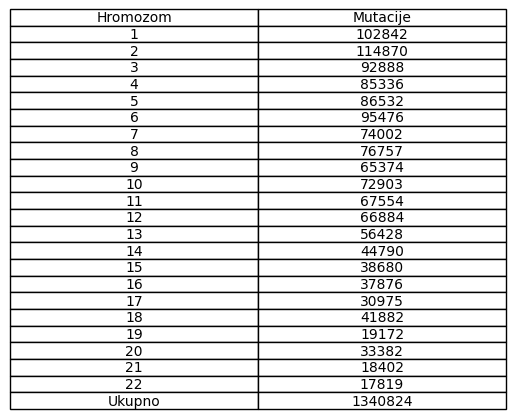

In [11]:
mutacije = list(vcf.fetch()) 
     
mutDic = dict()

ukupnoMutacija=0
for variant in vcf.fetch():
  ukupnoMutacija+=1
  mutDic[variant.chrom] = mutDic.get(variant.chrom,0)+1

tableItems = []
for [i,j] in mutDic.items():
  tableItems.append([i,j])

tableItems.append(['Ukupno', ukupnoMutacija])

table = plt.table(cellText=tableItems, colLabels= ["Hromozom", "Mutacije"], loc= 'center', cellLoc='center')


plt.axis('off')
plt.show()

3. [4 boda] Nacrtati sledeće histograme, pri čemu odvojeno prikazati podatke dobijene iz zdravih i obolelih pacijenata (po dva histograma na istom grafiku):  
  3a. [1 boda] Frekvencije ređih alela (minor allele frequency, MAF) za svaku mutaciju u studiji  
  3b. [1 boda] Procenat homozigotnih referentnih uzoraka za svaku mutacija u studiji  
  3c. [1 boda] Procenat homozigotnih alternativnih uzoraka za svaku mutacija u studiji  
  3d. [1 boda] Procenat heterozigotnih uzoraka za svaku mutacija u studiji     
  

In [12]:
cases = {x for x in vcf.header.samples if x.startswith('case')}
controls = {x for x in vcf.header.samples if x.startswith('control')}

homorefsCases = []
homorefsControls = []
homoaltsCases = []
homoaltsControls = []
heterosCases = []
heterosControls = []
maffreqCases = []
maffreqControls = []

def casesFrequency(mutation):
  casesCount = Counter([sum(mutation.samples[s]['GT']) for s in cases])
  sumCases = sum(casesCount.values())

  homozigotRefCase = casesCount[0] / sumCases #0/0
  heterozigotCase = casesCount[1] / sumCases #1/0 | 0/1
  homozigotAltCase = casesCount[2] / sumCases #1/1 

  #(2*Ref_allele)/(2*(Ref_allele + alternate_allele))
  #minCase = min(homozigotRefCase, homozigotAltCase)
  maffreqCases =  (2*homozigotRefCase) / (2*(homozigotRefCase + homozigotAltCase))
  return homozigotRefCase, homozigotAltCase, heterozigotCase, maffreqCases

def controlsFrequency(mutation):
  controlCount = Counter([sum(mutation.samples[s]['GT']) for s in cases])
  sumControl = sum(controlCount.values())

  homozigotRefControl = controlCount[0] / sumControl
  heterozigotControl = controlCount[1] / sumControl
  homozigotAltControl = controlCount[2] / sumControl
  

  #MAF za controls
  maffreqControl =  (2*homozigotRefControl) / (2*(homozigotRefControl + homozigotAltControl)) 
  #maffreqControl = 8
  return homozigotRefControl, homozigotAltControl, heterozigotControl, maffreqControl

for mutation in mutacije:
    refCases, altCases, hetCases, mafCase = casesFrequency(mutation)
    refControls, altControls, hetControls, mafControl = controlsFrequency(mutation)

    
    homorefsCases.append(refCases)
    homoaltsCases.append(altCases)
    heterosCases.append(hetCases)
    maffreqCases.append(mafCase)
   
    homorefsControls.append(refControls)
    homoaltsControls.append(altControls)
    heterosControls.append(hetControls)
    maffreqControls.append(mafControl)
    



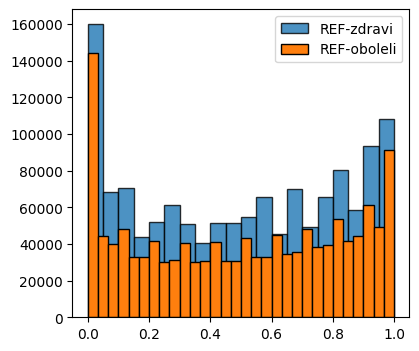

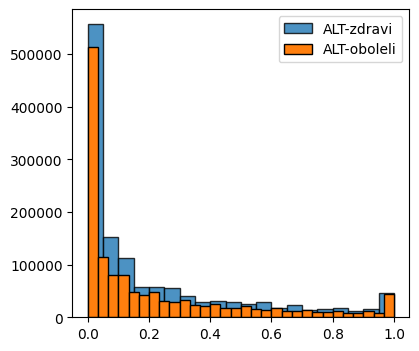

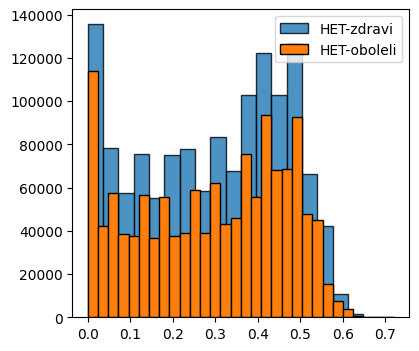

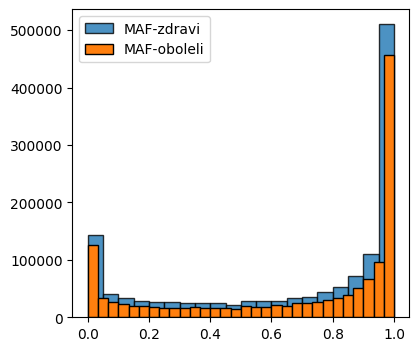

In [13]:
def plotFunc(label1, label2,case,control):
  plt.figure(figsize = (20,4))
  plt.subplot(1,4,2)
  plt.hist(control, bins= 20, edgecolor='black', alpha=0.8, label = label2)
  plt.hist(case, bins= 30, edgecolor='black', label = label1)
  plt.legend()
  plt.show()
  


plotFunc('REF-oboleli', 'REF-zdravi',homorefsCases,homorefsControls)
plotFunc('ALT-oboleli', 'ALT-zdravi',homoaltsCases,homoaltsControls)
plotFunc('HET-oboleli', 'HET-zdravi',heterosCases,heterosControls)
plotFunc('MAF-oboleli', 'MAF-zdravi',maffreqCases, maffreqControls)

4. [9 bodova] Identifikovati mutacije koje su statistički značajno asocirane sa datom bolešću (p manje od 0.05, upotrebom hi kvadrat testa).  
  4a. [3 boda] Primeniti hi kvadrat test na sve mutacije u studiji  
  

In [14]:
def hiKvadratFunc(m):

  caseCnt = Counter([sum(m.samples[s]['GT']) for s in cases])
  caseRefs = 2 * caseCnt[0] + caseCnt[1] #broj obolelih bez mutacije
  caseAlts = 2 * caseCnt[2] + caseCnt[1] #broj obolelih sa mutacijom

  controlCnt = Counter([sum(m.samples[s]['GT']) for s in controls])
  controlRefs = 2 * controlCnt[0] + controlCnt[1] #broj zdravih bez mutacije
  controlAlts = 2 * controlCnt[2] + controlCnt[1] #broj zdravih sa mutacijom

  total = caseAlts+ caseRefs + controlAlts + controlRefs
  
  expected = [(caseRefs + caseAlts)*(caseRefs + controlRefs)/total,
              (controlRefs + controlAlts)*(caseRefs + controlRefs)/total,
              (caseRefs + caseAlts)*(caseAlts + controlAlts)/total,
              (controlRefs + controlAlts)*(caseAlts + controlAlts)/total]
  
  return chisquare([caseRefs, controlRefs, caseAlts, controlAlts], expected).pvalue

In [ ]:

hiKvadrat = [(m.chrom, m.pos, hiKvadratFunc(m)) for m in mutacije]

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [15]:
i = 0
for x in hiKvadrat:
  i += 1
  print(x)
  if(i > 100):
    break


NameError: ignored

 4b. [2 boda] Da li je potrebno izvršiti korekciju za višestruko testiranje (odgovor dati napismeno)? Ukoliko jeste, objasniti kako, i primeniti je.  

4c. [1 bod] Nacrtati Menhetn grafikon. Voditi računa da su ose adekvatno anotirane i da dužina duž X ose alocirana svakom hromozomu bude proporcionalna dužini hromozoma.  

In [ ]:
import pandas as pd
from itertools import groupby
#x_osa = list(map(lambda x: x[1], hiKvadrat))
#y_osa = list(map(lambda x: -np.log10(x[2]), hiKvadrat))
pomeraj = []
xCor = 0
plt.figure(figsize=(23, 5))
results = {key: list(value) for key, value in groupby(hiKvadrat, key=lambda x: x[0])}

for chrom in results:
  pos = [x[1] for x in results[chrom]]                  #racuna "x" koordinate
  p_values = [-np.log10(x[2]) for x in results[chrom]]  #racuna "y" koordinate

  pomeraj.append(xCor + max(pos)/2)                     #racuna pomeraj za crtanje labela
  pos = list(map(lambda x: x + xCor, pos))              #dodaje pomeraj u desno za crtanje
  xCor = max(pos)                                       #uzima max od "x" koordinata za sledeci pomeraj, da bi se svi hromozomi odvojeno crtali
  plt.scatter(pos,p_values)
  
labele = [str(i) for i in range(1,23)]
plt.xticks(pomeraj, labele)
plt.show()






4d. [3 boda] Za svaku mutaciju koja je statistički značajno asocirana sa datom bolešću odrediti da li odstupa od Hardi-Vajnberg ekvilibrijuma (upotrebom hi kvadrat testa). Da li ima takcih mutacija? Da li je ovom prilikom potrebna korekcija za višestruko testiranje (obrazložiti)? 

In [ ]:
def hardyWeinberg(mutation):
  caseCnt = Counter([sum(sample['GT']) for sample in mutation.samples.values()])
  suma = sum(caseCnt.values())
  controls = (2* caseCnt[0] + caseCnt[1])
  cases = (2* caseCnt[2] + caseCnt[1])

  p = (controls) / 400
  q = (cases) / 400
  ##print(str(p) + ' ' + str(q))
  expected = [p**2*suma , 2*p*q*suma , q**2*suma]  # p^2 + 2pq + q^2 = 1 Hardy-Weinberg
  observed = [caseCnt[0] , caseCnt[1] , caseCnt[2]]
  return chisquare(observed,expected).pvalue

In [ ]:
#criticalValue = 0.01
#criticalApproved = []
#for mutacija in mutacije:
  #if hardyWeinberg(mutacija) < criticalValue:
    #criticalApproved.append(mutacija)
k = 0
for mutacija in mutacije:
  k = hardyWeinberg(mutacija)
  print(k)
